In [20]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [21]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [22]:
data_folder = '/content/drive/My Drive/cs6643final_project/data/'
model_folder = '/content/drive/My Drive/cs6643final_project/model/'
image_size = (224, 224)
batch_size = 32

In [23]:
from keras.preprocessing.image import ImageDataGenerator
# use keras data generator to generate more images by randomly rotate and flip the image in our dataset.
# set the range of rotation to be 30 degrees
data_generator = ImageDataGenerator(
        rotation_range=30,
        rescale=1.0/255,
        horizontal_flip=True,
        fill_mode="nearest")

test_data_generator = ImageDataGenerator(rescale=1.0/255)

In [24]:
train_data_gen = data_generator.flow_from_directory(
    data_folder + "train",
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=True,
    interpolation = "nearest"  
)

test_data_gen = test_data_generator.flow_from_directory(
    data_folder + "test",
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle=False     
)


Found 2156 images belonging to 13 classes.
Found 260 images belonging to 13 classes.


In [25]:
## try to classify the chess images by a simple cnn model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(13))
model.add(Activation('softmax'))

model.compile(optimizer= 'adam', loss = 'categorical_crossentropy', metrics= ['categorical_accuracy'])

In [10]:
## train the simple cnn model
epochs = 30

history = model.fit(
    train_data_gen,
    epochs = epochs,
    verbose = 1,
    validation_data = test_data_gen
)
model.save_weights(model_folder + "model_cnn.h5")

Epoch 1/30
68/68 [==============================] - 623s 9s/step - loss: 2.5070 - categorical_accuracy: 0.1206 - val_loss: 2.1921 - val_categorical_accuracy: 0.1462
Epoch 2/30
68/68 [==============================] - 26s 386ms/step - loss: 2.2191 - categorical_accuracy: 0.1605 - val_loss: 2.0272 - val_categorical_accuracy: 0.2154
Epoch 3/30
68/68 [==============================] - 26s 379ms/step - loss: 2.1196 - categorical_accuracy: 0.1814 - val_loss: 1.9763 - val_categorical_accuracy: 0.1923
Epoch 4/30
68/68 [==============================] - 26s 381ms/step - loss: 2.0310 - categorical_accuracy: 0.2032 - val_loss: 1.9061 - val_categorical_accuracy: 0.2500
Epoch 5/30
68/68 [==============================] - 26s 378ms/step - loss: 1.9761 - categorical_accuracy: 0.2064 - val_loss: 1.8601 - val_categorical_accuracy: 0.2808
Epoch 6/30
68/68 [==============================] - 26s 379ms/step - loss: 1.9291 - categorical_accuracy: 0.2319 - val_loss: 1.8475 - val_categorical_accuracy: 0.2654


In [26]:
## training a new model from starts cannot produce acceptable performance in terms of accuracy. The accuracy of the simple cnn model converges at around 0.4. Beyond 11 epoches, the model starts to be overfitting.

## switch to utlizing transfer learning on top of a pretrained model 
from keras.models import Model

In [27]:

from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import decode_predictions

# dont include the three fully connected layers at the top in order to build our model.
vgg = VGG16(weights="imagenet", include_top = False, input_shape= (224,224,3))
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [28]:
## load another pretrained model ResNet50
from keras.applications.resnet50 import ResNet50

resnet = ResNet50(include_top = False, weights = "imagenet", input_shape = (224,224,3))

resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [29]:
from keras.applications.vgg19 import VGG19

vgg19 = VGG19(include_top = False, weights = "imagenet", input_shape = (224,224,3))

vgg19.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [30]:
## freeze the pretrained models
for layer in vgg.layers:
  layer.trainable = False
for layer in resnet.layers:
  layer.trainable = False
for layer in vgg19.layers:
  layer.trainable = False
pretrained_models = [vgg, vgg19, resnet]
final_models = []
for model in pretrained_models:
  ## take the output of the pretrained model as the input of our model
  input  = model.output 
  ## flat the tensor output into 1D featuers
  flatten = Flatten()(input)
  ## add some fully connected layers on top of the flatten layer.
  ## need to tune the number of fully connected layer as hyperparameter
  ## number of nodes in the fully connected layers also need to be tuned
  fc1 = Dense(500, activation = "relu")(flatten)
  fc2 = Dense(500, activation = "relu")(fc1)
  ## add a fully connected layer for the output prediction
  output = Dense(13, activation = "softmax")(fc2)
  modified_model = Model(inputs = model.input, outputs = output)
  modified_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])
  final_models.append(modified_model)



In [ ]:
## train the two modified models 

In [15]:
## train modified vgg 16 first
epochs = 30

history0 = final_models[0].fit(
    train_data_gen,
    epochs = epochs,
    verbose = 1,
    validation_data = test_data_gen
)


Epoch 1/30
68/68 [==============================] - 1150s 16s/step - loss: 3.3548 - categorical_accuracy: 0.2035 - val_loss: 1.4954 - val_categorical_accuracy: 0.4538
Epoch 2/30
68/68 [==============================] - 35s 519ms/step - loss: 1.1900 - categorical_accuracy: 0.5818 - val_loss: 0.9336 - val_categorical_accuracy: 0.6231
Epoch 3/30
68/68 [==============================] - 36s 523ms/step - loss: 0.8318 - categorical_accuracy: 0.7115 - val_loss: 0.7871 - val_categorical_accuracy: 0.7000
Epoch 4/30
68/68 [==============================] - 36s 521ms/step - loss: 0.5672 - categorical_accuracy: 0.7886 - val_loss: 0.8521 - val_categorical_accuracy: 0.7038
Epoch 5/30
68/68 [==============================] - 35s 518ms/step - loss: 0.5197 - categorical_accuracy: 0.8102 - val_loss: 0.8243 - val_categorical_accuracy: 0.7000
Epoch 6/30
68/68 [==============================] - 35s 520ms/step - loss: 0.4483 - categorical_accuracy: 0.8492 - val_loss: 0.7106 - val_categorical_accuracy: 0.750

In [16]:
## save the training history to file
import numpy as np
np.save(model_folder + 'history0.npy', history0.history)

In [34]:
## train modified vgg19
epochs = 30

history1 = final_models[1].fit(
    train_data_gen,
    epochs = epochs,
    verbose = 1,
    validation_data = test_data_gen
)


Epoch 1/30
68/68 [==============================] - 39s 554ms/step - loss: 3.9031 - categorical_accuracy: 0.1509 - val_loss: 1.7827 - val_categorical_accuracy: 0.4038
Epoch 2/30
68/68 [==============================] - 38s 551ms/step - loss: 1.4391 - categorical_accuracy: 0.5088 - val_loss: 1.2604 - val_categorical_accuracy: 0.4885
Epoch 3/30
68/68 [==============================] - 37s 540ms/step - loss: 0.9894 - categorical_accuracy: 0.6546 - val_loss: 1.0441 - val_categorical_accuracy: 0.5846
Epoch 4/30
68/68 [==============================] - 37s 546ms/step - loss: 0.8092 - categorical_accuracy: 0.7125 - val_loss: 0.9199 - val_categorical_accuracy: 0.6615
Epoch 5/30
68/68 [==============================] - 37s 548ms/step - loss: 0.6939 - categorical_accuracy: 0.7434 - val_loss: 0.9719 - val_categorical_accuracy: 0.6577
Epoch 6/30
68/68 [==============================] - 37s 548ms/step - loss: 0.7219 - categorical_accuracy: 0.7544 - val_loss: 0.9687 - val_categorical_accuracy: 0.684

In [35]:
np.save(model_folder + 'history1.npy', history1.history)

In [ ]:
## The results shows that vgg16 has better 

In [18]:
epochs = 30

history2 = final_models[2].fit(
    train_data_gen,
    epochs = epochs,
    verbose = 1,
    validation_data = test_data_gen
)


Epoch 1/30
68/68 [==============================] - 33s 435ms/step - loss: 8.9991 - categorical_accuracy: 0.0809 - val_loss: 2.5918 - val_categorical_accuracy: 0.0769
Epoch 2/30
68/68 [==============================] - 28s 415ms/step - loss: 2.5852 - categorical_accuracy: 0.1005 - val_loss: 2.5928 - val_categorical_accuracy: 0.0769
Epoch 3/30
68/68 [==============================] - 28s 414ms/step - loss: 2.5375 - categorical_accuracy: 0.1075 - val_loss: 2.5581 - val_categorical_accuracy: 0.0538
Epoch 4/30
68/68 [==============================] - 28s 412ms/step - loss: 2.5178 - categorical_accuracy: 0.0952 - val_loss: 2.5093 - val_categorical_accuracy: 0.1577
Epoch 5/30
68/68 [==============================] - 28s 412ms/step - loss: 2.4217 - categorical_accuracy: 0.1562 - val_loss: 2.4738 - val_categorical_accuracy: 0.1231
Epoch 6/30
68/68 [==============================] - 28s 409ms/step - loss: 2.4933 - categorical_accuracy: 0.1226 - val_loss: 2.5705 - val_categorical_accuracy: 0.076

In [21]:
final_models[0].save_weights(model_folder + 'modified_vgg16.h5')
final_models[1].save_weights(model_folder + 'modified_vgg19.h5')
final_models[2].save_weights(model_folder  + 'modified_resnet.h5')

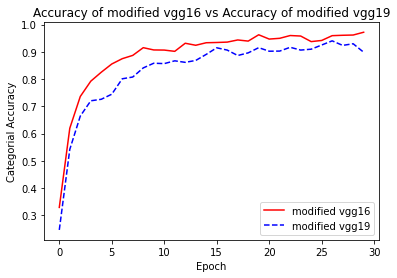

In [36]:
## the result shows that resnet is not suitable for this task

## compare the performance of vgg16 and vgg19 with validation accuracy
import seaborn as sea
import matplotlib.pyplot as plt


plt.title("Accuracy of modified vgg16 vs Accuracy of modified vgg19")
plt.xlabel("Epoch")
plt.ylabel("Categorial Accuracy")
plt.plot(history0.history['categorical_accuracy'], '-r', label = 'vgg16')
plt.plot(history1.history['categorical_accuracy'], '--b', label = 'vgg19')
plt.legend(["modified vgg16", "modified vgg19"])

In [31]:
## load model parameters
final_models[0].load_weights(model_folder + "modified_vgg16.h5")

In [37]:
## chose vgg16 as our choice

from sklearn.metrics import classification_report, confusion_matrix

labels = ['bb', 'bk', 'bn', 'bp', 'bq', 'br', 'empty', 'wb', 'wk', 'wn', 'wp', 'wq', 'wr']
test_data_gen.reset()
prediction = final_models[0].predict(test_data_gen)
y = np.argmax(prediction, axis = -1)
true_labels = test_data_gen.classes[test_data_gen.index_array]

cm = confusion_matrix(true_labels, y)
report = classification_report(true_labels, y, target_names = labels)

print("The confusion matrix of the prediction of modified vgg16")
print(cm)

print("The classification report of the prediction of modified vgg16")
print(report)

The confusion matrix of the prediction of modified vgg16
[[18  0  0  1  0  0  0  0  0  0  0  0  1]
 [ 1 17  0  0  1  1  0  0  0  0  0  0  0]
 [ 1  1 16  0  0  2  0  0  0  0  0  0  0]
 [ 4  0  0 16  0  0  0  0  0  0  0  0  0]
 [ 5  0  0  0 14  0  0  0  0  0  0  0  1]
 [ 2  0  1  0  0 17  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 19  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0 17  0  0  1  0  2]
 [ 0  0  0  0  0  0  0  2 12  0  0  4  2]
 [ 0  0  0  0  0  0  0  1  0 14  1  0  4]
 [ 0  0  0  0  0  0  0  2  0  0 18  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 19  1]
 [ 0  0  0  0  0  0  0  0  0  0  1  1 18]]
The classification report of the prediction of modified vgg16
              precision    recall  f1-score   support

          bb       0.58      0.90      0.71        20
          bk       0.94      0.85      0.89        20
          bn       0.94      0.80      0.86        20
          bp       0.94      0.80      0.86        20
          bq       0.93      0.70      0.80        20
         